In [1]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams['figure.dpi']=200
mpl.rc('xtick', labelsize=8) 
mpl.rc('ytick', labelsize=8) 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()] 

In [2]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [3]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))

CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


In [4]:
def statDict(whichStat):
    statNames=ghn.getStatKeyNames()
    fileName=statNames[whichStat]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    # Copy a network object to a local file
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)
    return statDict

In [5]:
statNames=ghn.getStatKeyNames()
tmaxArray=ghn.getVar(statDict(whichStat),'TMAX')
datesTmax, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict(whichStat),'TMIN')
datesTmin, tmin = zip(*tminArray)

In [6]:
datesTmax = np.array([np.datetime64(datesTmax[i]) for i in range(len(datesTmax))], 
                                                dtype='datetime64[D]')
dates_strmax = np.datetime_as_string(datesTmax)
dfmax = pd.DataFrame({'temperature': tmax}, index=pd.to_datetime(dates_strmax))
dfmax = dfmax.resample('D').asfreq()
dfmax.fillna(np.nan)

zerosmax = dfmax['temperature'].values
datearrmax = dfmax.index.values

maxtrain = dfmax.dropna()
tmaxtrain = maxtrain['temperature'].values
dmaxtrain = maxtrain.index.values.reshape(-1,1)

dmaxpred = dfmax[dfmax['temperature'].isna()].index.values.reshape(-1,1)

In [13]:
# from sklearn.ensemble import GradientBoostingRegressor
# gbmax = GradientBoostingRegressor(n_estimators=1000, max_depth=10)
# gbmax.fit(dmaxtrain, tmaxtrain)

# tmaxpred = gbmax.predict(dmaxpred)

# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(max_depth=10, random_state=0)

from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=1000)

clf.fit(dmaxtrain, tmaxtrain)
tmaxpred = clf.predict(dmaxpred)
dfmax.loc[dfmax['temperature'].isna(), 'temperature'] = tmaxpred

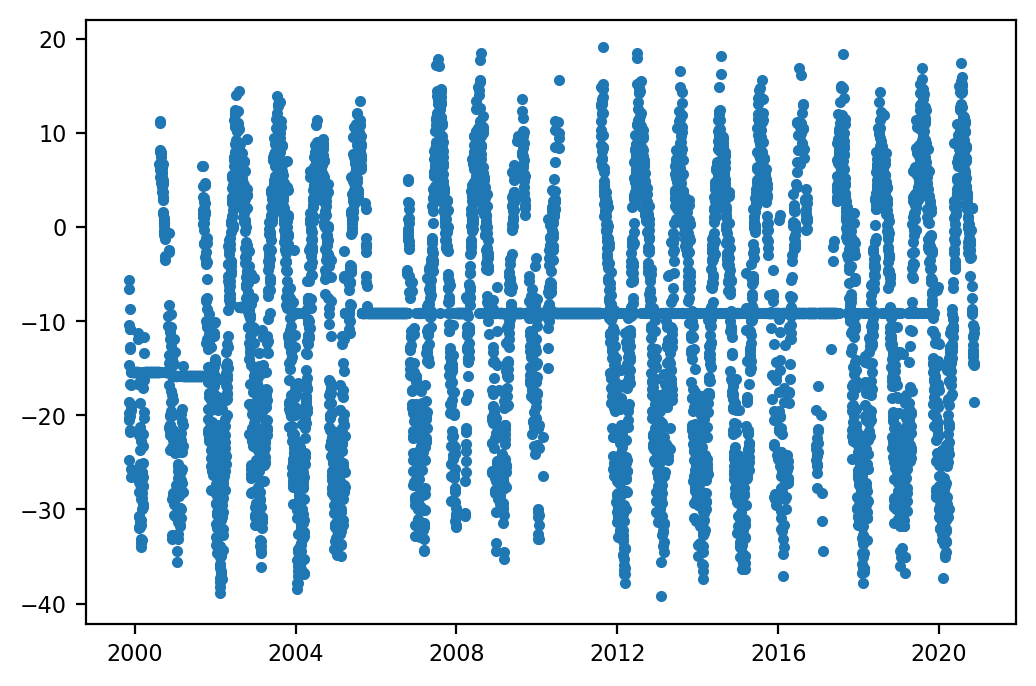

In [20]:
plt.plot(dfmax['temperature'],'.',label='tMax')